In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=3

import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib import Dataset
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

experiment_name = 'year_SDTR'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=3
cuda
experiment: year_SDTR_2020.07.16_14:27


In [2]:

data = Dataset("YEAR", random_state=1337, quantile_transform=True, quantile_noise=1e-3)
in_features = data.X_train.shape[1]
print(in_features)

mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid, data.y_test = map(normalize, [data.y_train, data.y_valid, data.y_test])

print("mean = %.5f, std = %.5f" % (mu, std))

90
mean = 1998.39193, std = 10.92832


In [3]:
from lib import DenseBlockSDTR, SDTR, Lambda

class DBSDTR(nn.Module):
    
    def __init__(self):
        super(DBSDTR, self).__init__()
        self.DBS = DenseBlockSDTR(in_features, 128, num_layers=1, tree_dim=3, depth=6, flatten_output=False,
                   Module=SDTR, hidden_dim=64)
        self.output_avg = Lambda(lambda x: x[..., 0].mean(dim=-1))
    
    def forward(self, x):
        output, reg = self.DBS(x)
        output = self.output_avg(output)
        return output, reg
model = DBSDTR().to(device, non_blocking=True)
print("Model built.")
with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:100], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Model built.


/home/fourier/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [4]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }


In [5]:
import lib
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [6]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 250
report_frequency = 50

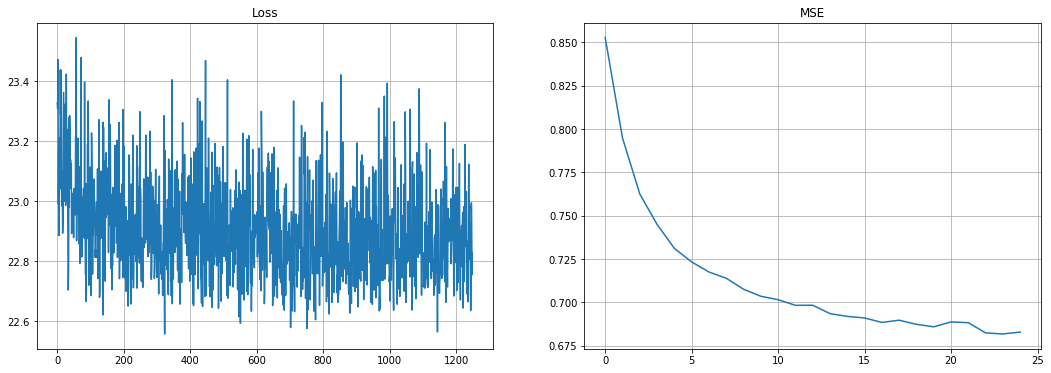

[1250] Loss 22.82623
Val MSE: 0.68289


/home/fourier/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:

for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=128, 
                                                shuffle=True, epochs=float('inf')):

    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])
    if trainer.step % report_frequency == 0:
        f = open("jupyter_out.txt", "a+")
        trainer.save_checkpoint()
        # trainer.average_checkpoints(out_tag='avg')
        # trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=16384)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        # trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("[%d] Loss %.5f" % (trainer.step, metrics['loss']))
        print("Val MSE: %0.5f" % (mse), flush=True)
        f.write("[%d] Loss %.5f,  Val MSE: %0.5f\n"%(trainer.step, metrics['loss'], mse))
        if trainer.step > best_step_mse + early_stopping_rounds:
            print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
            print("Best step: ", best_step_mse)
            print("Best Val MSE: %0.5f" % (best_mse))
            f.write("Best step: %d,  Best Val MSE: %0.5f"%(best_step_mse, best_mse))
            break
        f.close()




In [ ]:
f = open("jupyter_out.txt", "a+")
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(data.X_test, data.y_test, device=device)
f.write('Best step: ', trainer.step)
f.write("Test MSE: %0.5f" % (mse))
f.close()

In [ ]:
mse * std ** 2